In [3]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "02_ml_models/02b_neural_network.ipynb"
_nb_title = "Flowers Image Classification using a neural network"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/logo-cloud.png"/> Run in Vertex AI Workbench</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Flowers Image Classification using a neural network&url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fblob%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F02_ml_models%2F02b_neural_network.ipynb">
    <img src="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/logo-cloud.png"/> Run in Vertex AI Workbench</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/02_ml_models/02b_neural_network.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# ニューラルネットワークを使用した花の画像分類  

このノートブックでは、tf-flowersデータセットを分類するためのニューラルネットワークを構築する方法を示します。  

データ探索の多くは、コンパニオンノートブック02a_machine_perception.ipynbで行われました。  


## GPUを有効にする  

GPUを使用していれば、このノートブックを含むリポジトリ内のほとんどすべてのノートブックをより高速に実行することができます。

Colabの場合:
- [編集]→[ノートブック設定]へ移動
- [ハードウェアアクセラレータ]ドロップダウンから[GPU]を選択

Vertex AI の場合:
- https://console.cloud.google.com/vertex-ai/workbench/list/instances へ移動
- GPUを使用してインスタンスを作成するか、インスタンスを選択してGPUを追加します  

次に、Tensorflowを使用してGPUに接続できることを確認します。

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.2
Found GPU at: /device:GPU:0


2021-12-17 06:29:01.556637: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-17 06:29:02.216524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:02.225566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:02.226285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [3]:
# ヘルパー関数
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

# 検証用データセットからいくつかの画像を model.predict() で推論
def plot_predictions(filename):
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    dataset = (tf.data.TextLineDataset(filename).map(decode_csv))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
    # CLASS_NAMES: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
    LAYER = 1 # Layer = 0 は平坦化層(Flatten)、 Layer = 1 が最初の全結合層(Dense)
    WEIGHT_TYPE = 0 # 0 は重み(weight), 1 はバイアス(bias)

    f, ax = plt.subplots(1, 5, figsize=(15,15))
    for flower in range(len(CLASS_NAMES)):
        weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
        min_wt = tf.math.reduce_min(weights).numpy()
        max_wt = tf.math.reduce_max(weights).numpy()
        flower_name = CLASS_NAMES[flower]
        print("Scaling weights for {} in {} to {}".format(
            flower_name, min_wt, max_wt))
        weights = (weights - min_wt)/(max_wt - min_wt)
        ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
        ax[flower].set_title(flower_name);

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
    # ファイルを読み込む
    img = tf.io.read_file(filename)
    # 圧縮された文字列を3次元のuint8のテンソルに変換する
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # 3次元のuint8を[0, 1]の範囲の浮動小数点数に変換する
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 画像を必要なサイズにリサイズする
    return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# `CLASS_NAMES`列はラベルのインデックス
def decode_csv(csv_row):
    record_defaults = ["path", "flower"]
    filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2021-12-17 06:29:08.608869: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:08.609629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:08.610196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:08.611098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 06:29:08.611694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## ニューラルネットワーク(NN)モデル  

隠れ層に非線形レイヤーを1つ追加します

In [5]:
BATCH_SIZE = 32

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(BATCH_SIZE)

# 隠れ層ひとつのニューラルネットワーク
model = tf.keras.Sequential([
          tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
          tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
          tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

2021-12-17 06:29:12.829041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
104/104 [==============================] - 81s 765ms/step - loss: 18.6520 - accuracy: 0.3194 - val_loss: 6.0703 - val_accuracy: 0.3811
Epoch 2/10
104/104 [==============================] - 80s 770ms/step - loss: 5.2784 - accuracy: 0.4203 - val_loss: 9.4414 - val_accuracy: 0.3459
Epoch 3/10
104/104 [==============================] - 80s 766ms/step - loss: 4.9591 - accuracy: 0.4227 - val_loss: 5.7291 - val_accuracy: 0.3892
Epoch 4/10
104/104 [==============================] - 81s 780ms/step - loss: 3.6659 - accuracy: 0.4318 - val_loss: 5.5230 - val_accuracy: 0.3297
Epoch 5/10
104/104 [==============================] - 83s 799ms/step - loss: 2.0697 - accuracy: 0.5015 - val_loss: 2.0839 - val_accuracy: 0.3973
Epoch 6/10
104/104 [==============================] - 82s 790ms/step - loss: 1.4670 - accuracy: 0.5394 - val_loss: 2.6632 - val_accuracy: 0.3865
Epoch 7/10
104/104 [==============================] - 95s 915ms/step - loss: 1.4079 - accuracy: 0.5558 - val_loss: 5.0180 - val_a

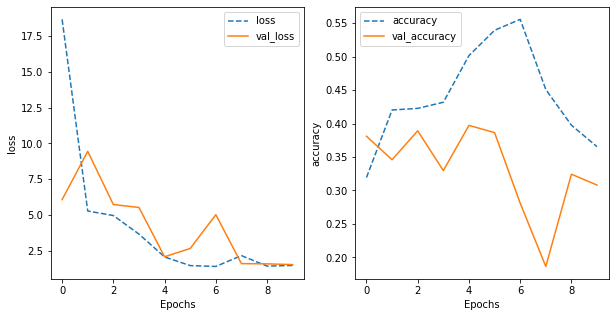

In [6]:
training_plot(['loss', 'accuracy'], history)

In [7]:
# 前のセルを、パラメトリックに操作できるように変更
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # Adam のデフォルト
                       l1 = 0,
                       l2 = 0,
                       num_hidden = 128):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(batch_size)

# 隠れ層ひとつのニューラルネットワーク
    model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Epoch 1/10
104/104 [==============================] - 80s 770ms/step - loss: 2.4339 - accuracy: 0.3703 - val_loss: 1.8027 - val_accuracy: 0.3541
Epoch 2/10
104/104 [==============================] - 80s 765ms/step - loss: 1.6272 - accuracy: 0.4252 - val_loss: 1.7915 - val_accuracy: 0.4135
Epoch 3/10
104/104 [==============================] - 79s 758ms/step - loss: 1.4380 - accuracy: 0.4700 - val_loss: 1.4735 - val_accuracy: 0.4514
Epoch 4/10
104/104 [==============================] - 81s 776ms/step - loss: 1.3125 - accuracy: 0.5024 - val_loss: 1.5507 - val_accuracy: 0.4730
Epoch 5/10
104/104 [==============================] - 79s 760ms/step - loss: 1.2290 - accuracy: 0.5318 - val_loss: 1.6754 - val_accuracy: 0.4541
Epoch 6/10
104/104 [==============================] - 79s 763ms/step - loss: 1.1727 - accuracy: 0.5600 - val_loss: 1.9031 - val_accuracy: 0.4270
Epoch 7/10
104/104 [==============================] - 79s 764ms/step - loss: 1.0870 - accuracy: 0.5991 - val_loss: 1.8241 - val_ac

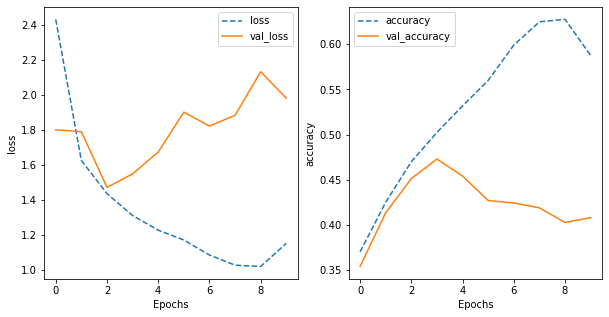

In [8]:
# 学習率を小さく変更
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=128)

Epoch 1/10
104/104 [==============================] - 82s 784ms/step - loss: 2.6957 - accuracy: 0.3455 - val_loss: 1.6136 - val_accuracy: 0.3892
Epoch 2/10
104/104 [==============================] - 80s 773ms/step - loss: 1.5678 - accuracy: 0.4264 - val_loss: 1.8657 - val_accuracy: 0.4135
Epoch 3/10
104/104 [==============================] - 80s 770ms/step - loss: 1.4469 - accuracy: 0.4688 - val_loss: 1.8127 - val_accuracy: 0.4270
Epoch 4/10
104/104 [==============================] - 83s 796ms/step - loss: 1.4112 - accuracy: 0.4912 - val_loss: 1.3198 - val_accuracy: 0.4838
Epoch 5/10
104/104 [==============================] - 81s 781ms/step - loss: 1.2053 - accuracy: 0.5306 - val_loss: 1.7492 - val_accuracy: 0.3892
Epoch 6/10
104/104 [==============================] - 80s 773ms/step - loss: 1.1309 - accuracy: 0.5606 - val_loss: 1.4024 - val_accuracy: 0.4486
Epoch 7/10
104/104 [==============================] - 80s 768ms/step - loss: 1.1102 - accuracy: 0.5833 - val_loss: 1.4334 - val_ac

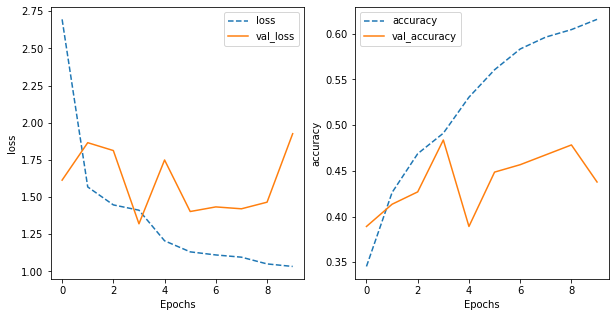

In [9]:
# 隠れ層のノードの数(`num_hidden`)を変更
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0, num_hidden=256)

Epoch 1/10
104/104 [==============================] - 80s 764ms/step - loss: 2.5934 - accuracy: 0.3497 - val_loss: 1.9526 - val_accuracy: 0.3811
Epoch 2/10
104/104 [==============================] - 87s 837ms/step - loss: 1.7650 - accuracy: 0.4255 - val_loss: 1.5061 - val_accuracy: 0.4622
Epoch 3/10
104/104 [==============================] - 83s 802ms/step - loss: 1.5720 - accuracy: 0.4652 - val_loss: 1.5410 - val_accuracy: 0.4541
Epoch 4/10
104/104 [==============================] - 92s 885ms/step - loss: 1.5005 - accuracy: 0.4933 - val_loss: 1.6368 - val_accuracy: 0.4514
Epoch 5/10
104/104 [==============================] - 102s 977ms/step - loss: 1.4660 - accuracy: 0.5158 - val_loss: 1.7517 - val_accuracy: 0.4297
Epoch 6/10
104/104 [==============================] - 100s 960ms/step - loss: 1.3839 - accuracy: 0.5291 - val_loss: 1.6397 - val_accuracy: 0.4514
Epoch 7/10
104/104 [==============================] - 84s 802ms/step - loss: 1.2722 - accuracy: 0.5739 - val_loss: 1.5641 - val_

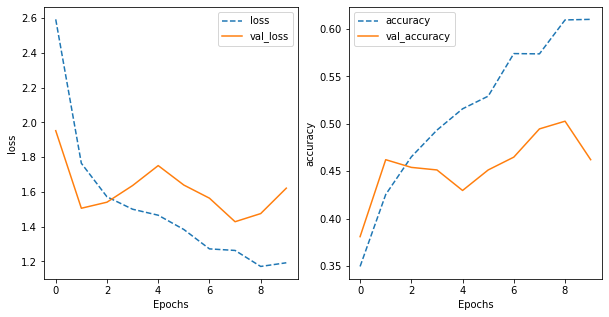

In [10]:
# L2正則化を追加
model = train_and_evaluate(batch_size=32, lrate=0.0001, l1=0, l2=0.001, num_hidden=128)

## ハイパーパラメータの調整

In [13]:
!pip install keras-tuner  --user

In [14]:
import kerastuner as kt

def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    l1 = 0
    l2 = hp.Choice('l2', values=[0.0, 1e-1, 1e-2, 1e-3, 1e-4])
    num_hidden = hp.Int('num_hidden', 32, 256, 32)

    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    # 隠れ層ひとつのニューラルネットワーク
    model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(num_hidden,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(len(CLASS_NAMES), 
                                    kernel_regularizer=regularizer,
                                    activation='softmax')
  ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

batch_size = 32
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(batch_size)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(batch_size) 

tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'), 
    max_trials=10,
    num_initial_points=2, 
    overwrite=False) # 最初から始める場合はTrueを指定する

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)]
)

topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())

Trial 10 Complete [00h 03m 02s]
val_accuracy: 0.4351351261138916

Best val_accuracy So Far: 0.47297295928001404
Total elapsed time: 00h 44m 08s
INFO:tensorflow:Oracle triggered exit
{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 160}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 160)               24084640  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 805       
Total params: 24,085,445
Trainable params: 24,085,445
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())
  

{'lrate': 0.0001, 'l2': 0.0001, 'num_hidden': 160}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 160)               24084640  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 805       
Total params: 24,085,445
Trainable params: 24,085,445
Non-trainable params: 0
_________________________________________________________________
None


ハイパーパラメータの最適な組み合わせ: （実行の度に異なります）
* l2 = 0.0001、lrate = 0.0001、num_hidden = 64
* score= 0.4595

## ディープニューラルネットワーク  

DNNをトレーニングしましょう。  
隠れ層数と各層のノードの数をパラメーター化します

In [16]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       num_hidden = [64, 16]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

    # 隠れ層ひとつのニューラルネットワーク
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    layers = layers + [
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='hidden_dense_{}'.format(hno))
          for hno, nodes in enumerate(num_hidden)
    ]
    layers = layers + [
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 9,634,981
Trainable params: 9,634,981
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
104/104 [==============================] - 80s 765ms/step - loss: 1.7954 - accuracy: 0.2370 - val_loss: 1.7603 - val_accuracy: 0.2351
Epoch 2/10
104/104 [==============================] - 84s 812ms/step - loss: 1.7530

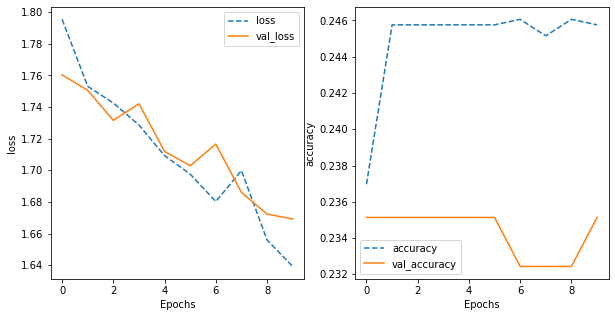

In [17]:
model = train_and_evaluate(lrate=0.0001, l2=0.001, num_hidden = [64, 16])

### ドロップアウトとバッチ正規化
各隠れ層の後にドロップアウトレイヤーとバッチ正規化レイヤーを追加します。  


In [19]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)

    train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

    eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

    # 隠れ層ひとつのニューラルネットワーク
    layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
    for hno, nodes in enumerate(num_hidden):
        layers.extend([
            tf.keras.layers.Dense(nodes,
                                kernel_regularizer=regularizer, 
                                name='hidden_dense_{}'.format(hno)),
            tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                             center=False, # have bias in Dense
                                             name='batchnorm_dense_{}'.format(hno)),
            # 活性化関数をBatchNormalizationの後に移動
            tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
            tf.keras.layers.Dropout(rate=dropout_prob,
                                 name='dropout_dense_{}'.format(hno)),                         
        ])

    layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    )

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

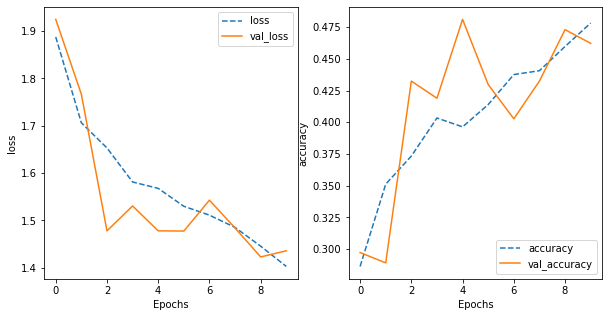

In [20]:
model = train_and_evaluate(dropout_prob=0.4)

## ダイアグラム  

これらでは本書の中で使用された図をプロットします。

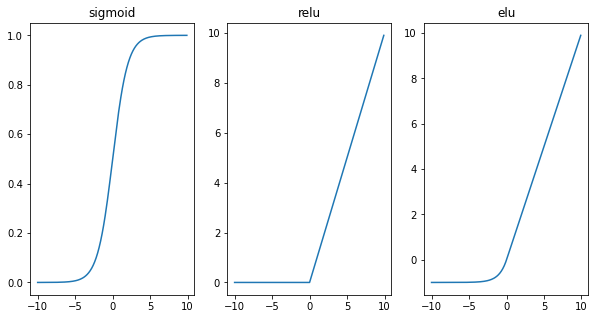

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


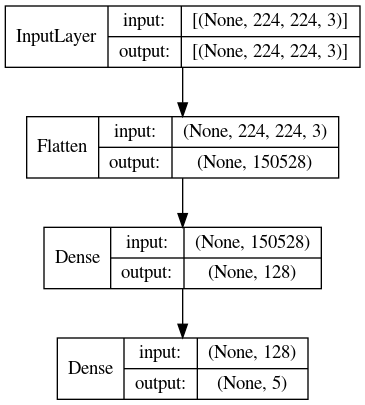

In [22]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation='relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [23]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.